## The Darcy's equation

We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function.
### (1.1) Neural Operator learning problem

The first example of Darcy flow is defined in a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

## (2) The Physics-informed Neural Operator method

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'DarcyFlow_smh'
tag = 'fdm'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/DarcyFlow_2d/smh_train.mat', 'r')
data_test = h5py.File('../../Problems/DarcyFlow_2d/smh_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
res = 29
######################################
from Utils.utils import *
n_train, n_test = 1000, 200
#
def get_data(data, ndata, res, res_coe=29, n0=0):
    # Data is of the shape (number of samples = 1000, grid size = 29*29)
    a = np2tensor(np.array(data["coeff"][...,n0:n0+ndata]).T, dtype)
    u = np2tensor(np.array(data["sol"][...,n0:n0+ndata]).T, dtype)
    beta1 = np2tensor(np.array(data["beta1"][n0:n0+ndata]), dtype)
    beta2 = np2tensor(np.array(data["beta2"][n0:n0+ndata]), dtype)
    #
    X, Y = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
    gridx = mesh.reshape(1, res, res, 2)
    #
    try:
        X_coe, Y_coe = np.array(data['X_coe']).T, np.array(data['Y_coe']).T
    except:
        X_coe, Y_coe = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np2tensor(np.vstack([X_coe.ravel(), Y_coe.ravel()]).T, dtype)
    gridx_coe = mesh.reshape(1, res_coe, res_coe, 2)
    ax = torch.cat([a.reshape(ndata, res_coe, res_coe,1), gridx_coe.repeat(ndata, 1, 1, 1)], dim=-1)
    #
    u = u.reshape(ndata, res, res, 1)
    
    return ax, u, gridx.reshape(-1,2), beta1, beta2
#
ax_train, u_train, gridx_train, beta1_train, beta2_train = get_data(data_train, n_train, res=res)
ax_test, u_test, gridx_test, beta1_test, beta2_test = get_data(data_test, n_test, res=res)
#
print('The shape of ax_train:', ax_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
print('The shape of beta1', beta1_train.shape, 'The shape of beta2', beta2_train.shape)
print('The shape of ax_test:', ax_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of gridx_test:', gridx_test.shape)
print('The shape of beta1', beta1_test.shape, 'The shape of beta2', beta2_test.shape)
######################################
# Generate mesh grids for calculating gradients
######################################
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
#
N_mesh = 29
x_mesh = pointGen.inner_point(N_mesh, method='mesh')
print('x_mesh shape:', x_mesh.shape)

<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
The shape of ax_train: torch.Size([1000, 29, 29, 3])
The shape of u_train: torch.Size([1000, 29, 29, 1])
The shape of gridx_train: torch.Size([841, 2])
The shape of beta1 torch.Size([1000, 1]) The shape of beta2 torch.Size([1000, 1])
The shape of ax_test: torch.Size([200, 29, 29, 3])
The shape of u_test: torch.Size([200, 29, 29, 1])
The shape of gridx_test: torch.Size([841, 2])
The shape of beta1 torch.Size([200, 1]) The shape of beta2 torch.Size([200, 1])
x_mesh shape: torch.Size([841, 2])


### (3.2) Define the loss class

In [2]:
###############################
# Define Loss Class
###############################
from Utils.Grad import *
from torch.autograd import grad, Variable

# #####################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, ax):
        x_mesh, y_mesh = ax[..., 1:2], ax[..., 2:3]
        u = u * torch.sin(np.pi * x_mesh)*torch.sin(np.pi * y_mesh)
        return u

##############################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.mollifer = mollifer()
        self.fun_a = fun_a
        self.model_u = solver.model_dict['u']
        #
        self.x_mesh = x_mesh.to(self.device)
        self.deltax = 1/(N_mesh-1)
        self.deltay = 1/(N_mesh-1)

    def Loss_pde(self, ax, w_pde, u_true=None):
        '''Define the PDE loss
        '''
        if w_pde>0.:
            n_batch = ax.shape[0]
            ########################
            x = Variable(self.x_mesh.repeat(n_batch, 1, 1), requires_grad=True)
            a = self.fun_a(x, ax[...,0:1].reshape(n_batch, -1, 1)) 
            x = x.reshape(-1, N_mesh, N_mesh, 2)
            a = a.reshape(-1, N_mesh, N_mesh, 1)
            ax = torch.cat([a,x], dim=-1)
            #
            u = self.model_u(ax)
            u = self.mollifer(u, ax)
            # 
            if (self.deltax is not None) and (self.deltay is not None):
                dudx, dudy = FDM_2d(u, self.deltax, self.deltay) 
                adux = ax[:,1:-1,1:-1,0:1] * dudx
                aduy = ax[:,1:-1,1:-1,0:1] * dudy 
                dauxdx, _ = FDM_2d(adux, self.deltax, self.deltay) 
                _, dauydy = FDM_2d(aduy, self.deltax, self.deltay) 
            else:
                x_mesh, y_mesh = ax[...,1:2], ax[...,2:3]
                dudx, dudy = FDM_2d(u, x_mesh, y_mesh) 
                adux = ax[:,1:-1,1:-1,0:1] * dudx 
                aduy = ax[:,1:-1,1:-1,0:1] * dudy 
                dauxdx, _ = FDM_2d(adux, x_mesh[:,1:-1,1:-1,:], y_mesh[:,1:-1,1:-1,:]) 
                _, dauydy = FDM_2d(aduy, x_mesh[:,1:-1,1:-1,:], y_mesh[:,1:-1,1:-1,:]) 
            #
            left = (- (dauxdx + dauydy)).reshape(n_batch, -1)
            right = 10. * torch.ones_like(left)
            
            return self.solver.getLoss(left, right)
        else:
            return torch.tensor(0.)
        
    def Loss_data(self, ax, u, w_data):
        '''Define the data loss
        '''
        if w_data>0:
            try: 
                u_pred = self.model_u(ax)
                u_pred = self.mollifer(u_pred, ax)
                return self.solver.getLoss(u_pred, u)
            except:
                return torch.tensor(0.)
        else:
            return torch.tensor(0.)
        
    def Error(self, ax, u):
        '''Define the Error
        '''
        try:
            u_pred = self.model_u(ax)
            u_pred = self.mollifer(u_pred, ax)
            return self.solver.getError(u_pred, u)
        except:
            return torch.tensor(0.)

######################################
# Steups of the model
######################################
from Solvers.PINO import PINO
solver = PINO.Solver(device, dtype)
netType = 'FNO2d'
#######################################
fun_a = solver.getModel_a(Exact_a=None, approximator='RBF', 
                          **{'x_mesh':gridx_train, 'kernel':'gaussian', 
                             'eps':25., 'smoothing':0., 'degree':6.})
###################################### The u and a model
layer_list = [80]*6
model_u = solver.getModel(in_size=3, out_size=1, modes=[15, 15], 
                          hidden_list=layer_list, netType='FNO2d')

##################
total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

17,329,697 training parameters.


### (2.3) training and make prediction

#### (2.3.1) train the model

In [3]:
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR',
                   gamma=0.6, step_size=200)
solver.train(LossClass, ax_train, u_train, ax_test, u_test, 
             w_data=0., w_pde=1., batch_size=50, epochs=2000, epoch_show=50, 
             **{'save_path':f'saved_models/PINO_{tag}/'})

  2%|█▌                                                              | 50/2000 [00:53<32:01,  1.01it/s]

Epoch:50 Time:53.3044, loss:4.2316, loss_pde:4.2316, loss_pde:0.0000
                l2_test:0.0322, lr:0.001


  5%|███▏                                                           | 100/2000 [01:44<33:21,  1.05s/it]

Epoch:100 Time:104.0094, loss:2.8970, loss_pde:2.8970, loss_pde:0.0000
                l2_test:0.0262, lr:0.001


  8%|████▋                                                          | 150/2000 [02:33<30:15,  1.02it/s]

Epoch:150 Time:153.7368, loss:3.0081, loss_pde:3.0081, loss_pde:0.0000
                l2_test:0.0363, lr:0.001


 10%|██████▎                                                        | 200/2000 [03:23<28:07,  1.07it/s]

Epoch:200 Time:203.0116, loss:4.1073, loss_pde:4.1073, loss_pde:0.0000
                l2_test:0.0277, lr:0.0006


 12%|███████▉                                                       | 250/2000 [04:10<27:24,  1.06it/s]

Epoch:250 Time:250.4387, loss:2.2776, loss_pde:2.2776, loss_pde:0.0000
                l2_test:0.0277, lr:0.0006


 15%|█████████▍                                                     | 300/2000 [04:57<27:14,  1.04it/s]

Epoch:300 Time:297.9041, loss:1.6619, loss_pde:1.6619, loss_pde:0.0000
                l2_test:0.0293, lr:0.0006


 18%|███████████                                                    | 350/2000 [05:44<25:43,  1.07it/s]

Epoch:350 Time:344.8394, loss:1.4522, loss_pde:1.4522, loss_pde:0.0000
                l2_test:0.0277, lr:0.0006


 20%|████████████▌                                                  | 400/2000 [06:31<25:58,  1.03it/s]

Epoch:400 Time:391.9512, loss:1.4858, loss_pde:1.4858, loss_pde:0.0000
                l2_test:0.0284, lr:0.00035999999999999997


 22%|██████████████▏                                                | 450/2000 [07:21<25:24,  1.02it/s]

Epoch:450 Time:441.1049, loss:1.5389, loss_pde:1.5389, loss_pde:0.0000
                l2_test:0.0242, lr:0.00035999999999999997


 25%|███████████████▊                                               | 500/2000 [08:10<24:34,  1.02it/s]

Epoch:500 Time:490.2689, loss:1.0765, loss_pde:1.0765, loss_pde:0.0000
                l2_test:0.0254, lr:0.00035999999999999997


 28%|█████████████████▎                                             | 550/2000 [08:59<23:46,  1.02it/s]

Epoch:550 Time:539.4381, loss:1.4335, loss_pde:1.4335, loss_pde:0.0000
                l2_test:0.0283, lr:0.00035999999999999997


 30%|██████████████████▉                                            | 600/2000 [09:47<22:33,  1.03it/s]

Epoch:600 Time:587.9553, loss:0.9960, loss_pde:0.9960, loss_pde:0.0000
                l2_test:0.0259, lr:0.00021599999999999996


 32%|████████████████████▍                                          | 650/2000 [10:36<21:37,  1.04it/s]

Epoch:650 Time:636.0953, loss:0.6193, loss_pde:0.6193, loss_pde:0.0000
                l2_test:0.0269, lr:0.00021599999999999996


 35%|██████████████████████                                         | 700/2000 [11:24<20:46,  1.04it/s]

Epoch:700 Time:684.1302, loss:0.6122, loss_pde:0.6122, loss_pde:0.0000
                l2_test:0.0264, lr:0.00021599999999999996


 38%|███████████████████████▋                                       | 750/2000 [12:11<19:51,  1.05it/s]

Epoch:750 Time:731.8726, loss:0.5286, loss_pde:0.5286, loss_pde:0.0000
                l2_test:0.0259, lr:0.00021599999999999996


 40%|█████████████████████████▏                                     | 800/2000 [12:59<19:01,  1.05it/s]

Epoch:800 Time:779.5388, loss:0.5941, loss_pde:0.5941, loss_pde:0.0000
                l2_test:0.0267, lr:0.00012959999999999998


 42%|██████████████████████████▊                                    | 850/2000 [13:47<18:16,  1.05it/s]

Epoch:850 Time:827.2915, loss:0.3616, loss_pde:0.3616, loss_pde:0.0000
                l2_test:0.0261, lr:0.00012959999999999998


 45%|████████████████████████████▎                                  | 900/2000 [14:34<17:13,  1.06it/s]

Epoch:900 Time:874.9590, loss:0.3502, loss_pde:0.3502, loss_pde:0.0000
                l2_test:0.0264, lr:0.00012959999999999998


 48%|█████████████████████████████▉                                 | 950/2000 [15:23<16:52,  1.04it/s]

Epoch:950 Time:923.0139, loss:0.4073, loss_pde:0.4073, loss_pde:0.0000
                l2_test:0.0259, lr:0.00012959999999999998


 50%|███████████████████████████████                               | 1000/2000 [16:10<15:55,  1.05it/s]

Epoch:1000 Time:970.9959, loss:0.3388, loss_pde:0.3388, loss_pde:0.0000
                l2_test:0.0256, lr:7.775999999999999e-05


 52%|████████████████████████████████▌                             | 1050/2000 [16:58<15:10,  1.04it/s]

Epoch:1050 Time:1018.8756, loss:0.3748, loss_pde:0.3748, loss_pde:0.0000
                l2_test:0.0259, lr:7.775999999999999e-05


 55%|██████████████████████████████████                            | 1100/2000 [17:46<14:24,  1.04it/s]

Epoch:1100 Time:1066.7731, loss:0.2085, loss_pde:0.2085, loss_pde:0.0000
                l2_test:0.0260, lr:7.775999999999999e-05


 57%|███████████████████████████████████▋                          | 1150/2000 [18:34<13:36,  1.04it/s]

Epoch:1150 Time:1114.8588, loss:0.2352, loss_pde:0.2352, loss_pde:0.0000
                l2_test:0.0260, lr:7.775999999999999e-05


 60%|█████████████████████████████████████▏                        | 1200/2000 [19:22<12:50,  1.04it/s]

Epoch:1200 Time:1162.9913, loss:0.2746, loss_pde:0.2746, loss_pde:0.0000
                l2_test:0.0262, lr:4.665599999999999e-05


 62%|██████████████████████████████████████▊                       | 1250/2000 [20:11<12:01,  1.04it/s]

Epoch:1250 Time:1211.1784, loss:0.1782, loss_pde:0.1782, loss_pde:0.0000
                l2_test:0.0260, lr:4.665599999999999e-05


 65%|████████████████████████████████████████▎                     | 1300/2000 [20:59<11:12,  1.04it/s]

Epoch:1300 Time:1259.3473, loss:0.1907, loss_pde:0.1907, loss_pde:0.0000
                l2_test:0.0259, lr:4.665599999999999e-05


 68%|█████████████████████████████████████████▊                    | 1350/2000 [21:47<10:29,  1.03it/s]

Epoch:1350 Time:1307.5444, loss:0.2806, loss_pde:0.2806, loss_pde:0.0000
                l2_test:0.0260, lr:4.665599999999999e-05


 70%|███████████████████████████████████████████▍                  | 1400/2000 [22:35<09:36,  1.04it/s]

Epoch:1400 Time:1355.5593, loss:0.2321, loss_pde:0.2321, loss_pde:0.0000
                l2_test:0.0265, lr:2.7993599999999992e-05


 72%|████████████████████████████████████████████▉                 | 1450/2000 [23:23<08:50,  1.04it/s]

Epoch:1450 Time:1403.8115, loss:0.1330, loss_pde:0.1330, loss_pde:0.0000
                l2_test:0.0261, lr:2.7993599999999992e-05


 75%|██████████████████████████████████████████████▌               | 1500/2000 [24:11<08:02,  1.04it/s]

Epoch:1500 Time:1451.9847, loss:0.1155, loss_pde:0.1155, loss_pde:0.0000
                l2_test:0.0262, lr:2.7993599999999992e-05


 78%|████████████████████████████████████████████████              | 1550/2000 [25:00<07:13,  1.04it/s]

Epoch:1550 Time:1500.0828, loss:0.1167, loss_pde:0.1167, loss_pde:0.0000
                l2_test:0.0261, lr:2.7993599999999992e-05


 80%|█████████████████████████████████████████████████▌            | 1600/2000 [25:48<06:24,  1.04it/s]

Epoch:1600 Time:1548.1417, loss:0.1308, loss_pde:0.1308, loss_pde:0.0000
                l2_test:0.0260, lr:1.6796159999999994e-05


 82%|███████████████████████████████████████████████████▏          | 1650/2000 [26:36<05:35,  1.04it/s]

Epoch:1650 Time:1596.1991, loss:0.1260, loss_pde:0.1260, loss_pde:0.0000
                l2_test:0.0259, lr:1.6796159999999994e-05


 85%|████████████████████████████████████████████████████▋         | 1700/2000 [27:24<04:49,  1.04it/s]

Epoch:1700 Time:1644.4385, loss:0.1367, loss_pde:0.1367, loss_pde:0.0000
                l2_test:0.0259, lr:1.6796159999999994e-05


 88%|██████████████████████████████████████████████████████▎       | 1750/2000 [28:12<03:59,  1.04it/s]

Epoch:1750 Time:1692.6682, loss:0.0995, loss_pde:0.0995, loss_pde:0.0000
                l2_test:0.0260, lr:1.6796159999999994e-05


 90%|███████████████████████████████████████████████████████▊      | 1800/2000 [29:00<03:12,  1.04it/s]

Epoch:1800 Time:1740.8056, loss:0.0983, loss_pde:0.0983, loss_pde:0.0000
                l2_test:0.0259, lr:1.0077695999999996e-05


 92%|█████████████████████████████████████████████████████████▎    | 1850/2000 [29:48<02:24,  1.04it/s]

Epoch:1850 Time:1788.9520, loss:0.1017, loss_pde:0.1017, loss_pde:0.0000
                l2_test:0.0259, lr:1.0077695999999996e-05


 95%|██████████████████████████████████████████████████████████▉   | 1900/2000 [30:37<01:35,  1.04it/s]

Epoch:1900 Time:1837.0561, loss:0.0935, loss_pde:0.0935, loss_pde:0.0000
                l2_test:0.0259, lr:1.0077695999999996e-05


 98%|████████████████████████████████████████████████████████████▍ | 1950/2000 [31:25<00:48,  1.04it/s]

Epoch:1950 Time:1885.1432, loss:0.0859, loss_pde:0.0859, loss_pde:0.0000
                l2_test:0.0260, lr:1.0077695999999996e-05


100%|██████████████████████████████████████████████████████████████| 2000/2000 [32:13<00:00,  1.03it/s]

Epoch:2000 Time:1933.4266, loss:0.0752, loss_pde:0.0752, loss_pde:0.0000
                l2_test:0.0260, lr:6.046617599999998e-06


The total training time is 1933.6821


### (3.3) load saved model and make prediction

The shape of u_test: torch.Size([200, 29, 29, 1]) u_pred: torch.Size([200, 29, 29, 1])
The test loss (avg): tensor(0.1395)
The test l2 error (avg): tensor(0.0326)


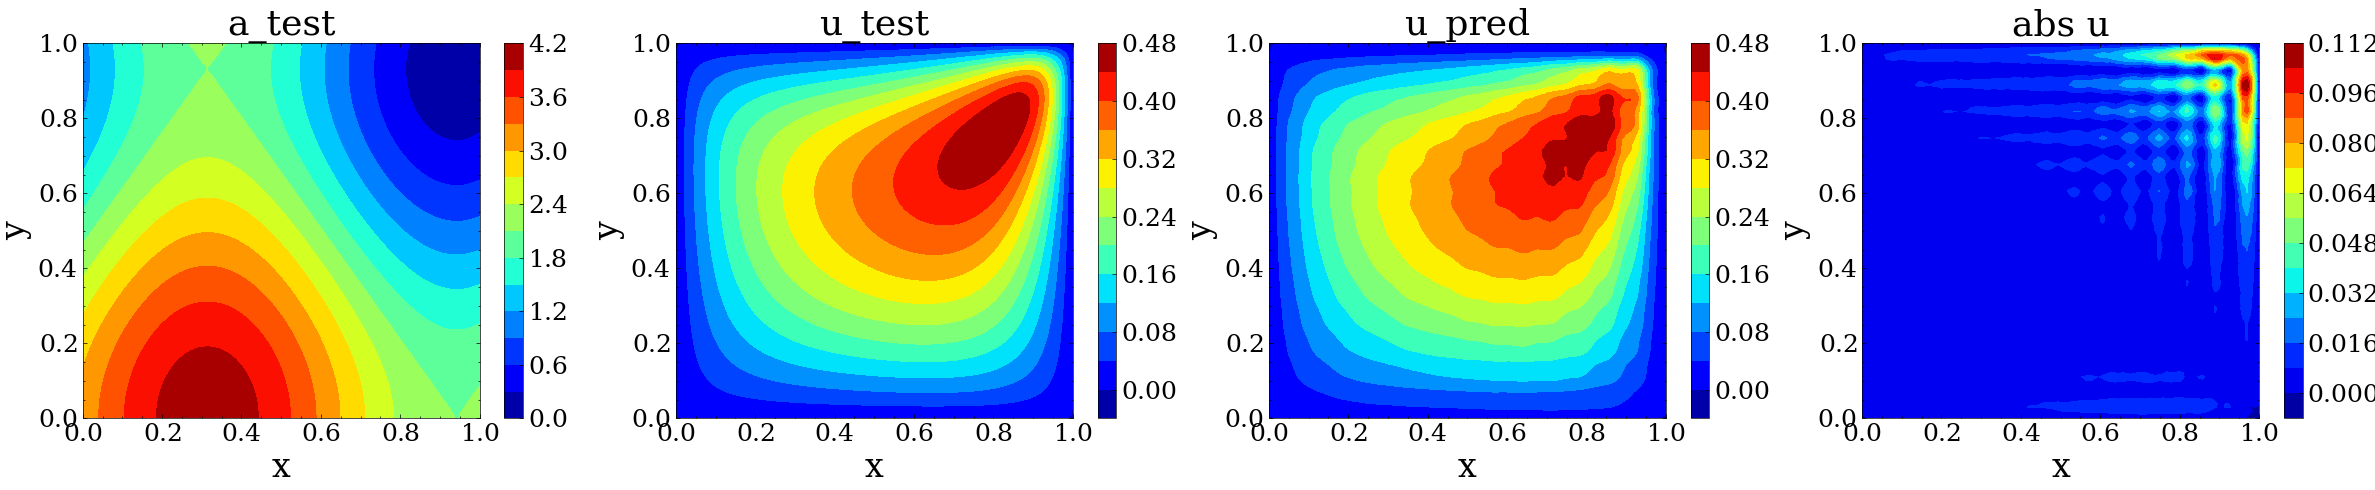

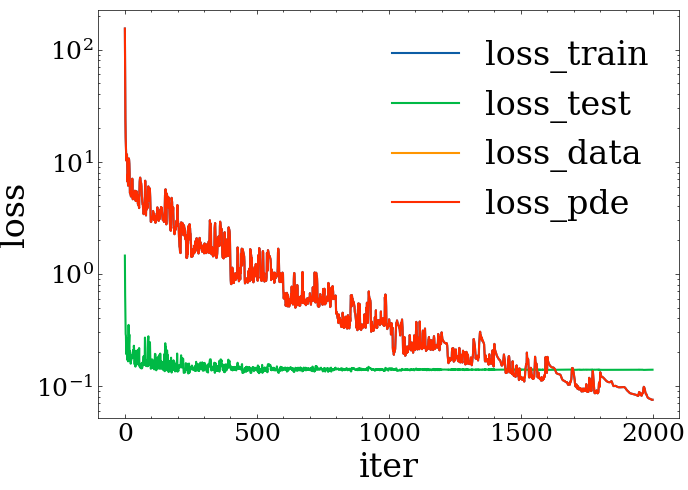

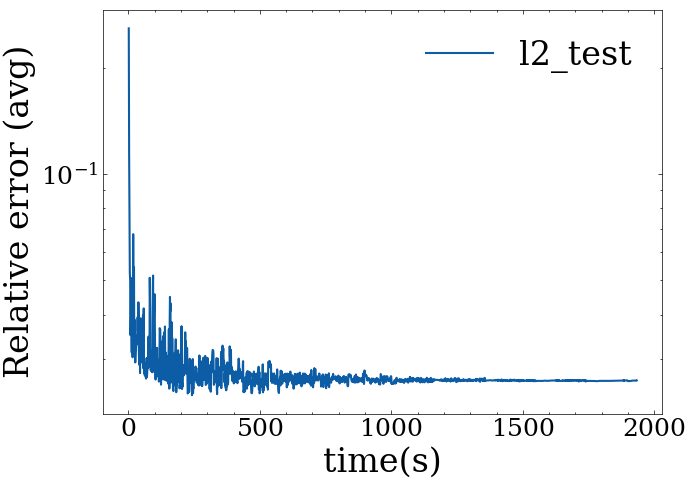

In [3]:
# #######################################
# # Load the trained model
# #######################################
from Solvers.PINO import PINO
solver = PINO.Solver(device, dtype)
tag = 'fdm'
model_trained = solver.loadModel(path=f'saved_models/PINO_{tag}/', name=f'model_pino_final')

#########################################
u_pred = model_trained['u'](ax_test.to(device))
u_pred = mollifer()(u_pred, ax_test.to(device)).detach().cpu()
#
print('The shape of u_test:', u_test.shape, 'u_pred:', u_pred.shape)
print('The test loss (avg):', solver.getLoss(u_pred, u_test))
print('The test l2 error (avg):', solver.getError(u_pred.reshape(1,-1), u_test.reshape(1,-1)))
inx = 0
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([gridx_train]+[gridx_test]*3, [ax_test[inx,...,0:1], u_test[inx], u_pred[inx], torch.abs(u_test[inx]-u_pred[inx])], 
                  ['a_test', 'u_test', 'u_pred', 'abs u'], lb =0.)
############################################# show loss and error
from Utils.PlotFigure import Plot
#
loss_saved = solver.loadLoss(path=f'saved_models/PINO_{tag}/', name='loss_pino')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_test', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])